In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
# import seaborn as sns
import numpy as np

In [3]:
df=pd.read_csv('/content/drive/My Drive/OIL/oildata.csv')

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
# Convert Effective date type to datetime
df["DATE"] = pd.to_datetime(df["DATE"])

# Remove timezone from effective date column
# df['DATE'] = pd.to_datetime(df['DATE']).dt.tz_localize(None)
df.head(2)

,DATE,DCOILWTICO
0,2019-05-30,56.47
1,2019-05-31,53.49


In [ ]:
adf_result = adfuller(df['DCOILWTICO'])

# Extract and print the test results
adf_statistic = adf_result[0]
p_value = adf_result[1]
critical_values = adf_result[4]

is_stationary = p_value < 0.05  # Typical significance level

print(f"ADF Statistic: {adf_statistic}")
print(f"p-value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"   {key}: {value}")

if is_stationary:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")

ADF Statistic: -1.64359353893201
p-value: 0.4603836875392433
Critical Values:
   1%: -3.435592223709696
   5%: -2.8638549702604803
   10%: -2.56800251776
The time series is not stationary.


<Figure size 1200x2000 with 0 Axes>

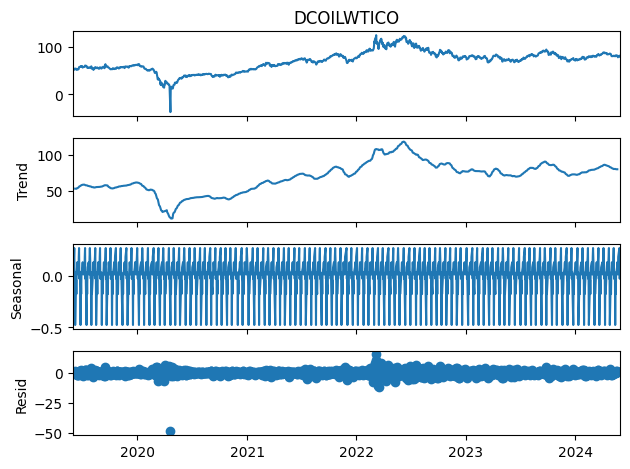

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

df.set_index('DATE', inplace=True)

# Decompose the time series
result = seasonal_decompose(df['DCOILWTICO'], model='additive', period=12)

# Plot the decomposition
plt.figure(figsize=(12, 20).dpi=150)
result.plot()
plt.show()

# Accessing the components
trend = result.trend
seasonal = result.seasonal
resid = result.resid



In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

<Figure size 1200x600 with 0 Axes>

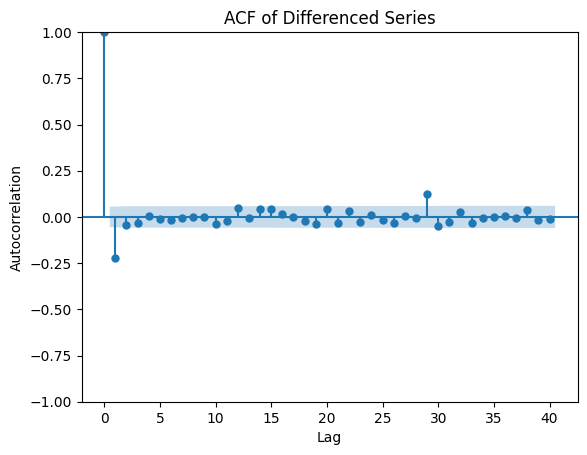

In [ ]:
plt.figure(figsize=(12, 6))
plot_acf(df['DCOILWTICO'].dropna(), lags=40)  # You can adjust lags as needed
plt.title('ACF of Differenced Series')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

However, a more mathematical test can be employed to determine which order is best for the data in question. The Augmented Dickey-Fuller test is one such measure that statsmodel readily provides. The ADF test aims to reject the null hypothesis that the given time-series data is non-stationary. It calculates the p-value and compares it with a threshold value or significance level of 0.05. If the p-value is less than this level, then the data is stationary; else, the differencing order is incremented by one.

In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Sample data preparation (replace this with your actual data)
# df = pd.read_csv('your_data.csv')  # Load your actual data here

# Perform ADF test on the original series
adf_result_original = adfuller(df['DCOILWTICO'])
p_value_original = adf_result_original[1]  # p-value of the original series

# Perform ADF test on the first difference
adf_result_diff1 = adfuller(df['DCOILWTICO'].diff().dropna())
p_value_diff1 = adf_result_diff1[1]  # p-value of the first difference

# Perform ADF test on the second difference
adf_result_diff2 = adfuller(df['DCOILWTICO'].diff().diff().dropna())
p_value_diff2 = adf_result_diff2[1]  # p-value of the second difference

# Print the results
print(f"Original Series p-value: {p_value_original}")
print(f"First Difference p-value: {p_value_diff1}")
print(f"Second Difference p-value: {p_value_diff2}")


Original Series p-value: 0.4603836875392433
First Difference p-value: 0.0
Second Difference p-value: 3.196015302968002e-26


As we see above, after the 2nd order differencing, the p-value drops beyond the acceptable threshold. Thus, we can consider the order of differencing (“d”) as 2. This corresponds well with the autocorrelation line graph seen above. However, the p-value for the 1st order is much closer to the threshold, so to be conservative, we will consider “d” as 1 and see how the model performs.

In [ ]:
model = ARIMA(df['DCOILWTICO'].dropna(), order=(1, 1, 1))
model_fit = model.fit()

In [ ]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             DCOILWTICO   No. Observations:                 1254
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3022.841
Date:                Sat, 26 Oct 2024   AIC                           6051.683
Time:                        09:03:14   BIC                           6067.083
Sample:                             0   HQIC                          6057.471
                               - 1254                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2877      0.043      6.698      0.000       0.204       0.372
ma.L1         -0.5409      0.042    -12.952      0.000      -0.623      -0.459
sigma2         7.2937      0.034    213.416      0.0

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
train_data = df['DCOILWTICO'].iloc[:1100]
test_data = df['DCOILWTICO'].iloc[1100:]
# Fit SARIMA model (adjust parameters as needed)
model1 = SARIMAX(train_data, order=(2, 1, 3), seasonal_order=(1, 1, 1, 12))
model_fit1 = model1.fit()

# Alternatively, use auto_arima to find the best parameters
model_auto = auto_arima(train_data, seasonal=True, m=12, stepwise=True, trace=True)
model_auto_fit = model_auto.fit(train_data)

# Get predictions
start = len(train_data)
end = start + len(test_data) - 1
pred = model_fit1.get_prediction(start=start, end=end, dynamic=False)
pred_ci = pred.conf_int()



Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=5419.664, Time=7.66 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5490.150, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5431.354, Time=0.50 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5418.992, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5488.246, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=5419.444, Time=0.15 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=5420.769, Time=1.30 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=5420.819, Time=1.50 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=5419.056, Time=0.48 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=5422.769, Time=6.68 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=5489.765, Time=0.34 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=5415.056, Time=0.92 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=5415.957, Time=0.36 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=5416.868, Time=1.82 sec
 ARIMA(1,1,1)(0,0,2

Training MSE: 11.98
Training RMSE: 3.46
Test MSE: 112.29
Test RMSE: 10.60


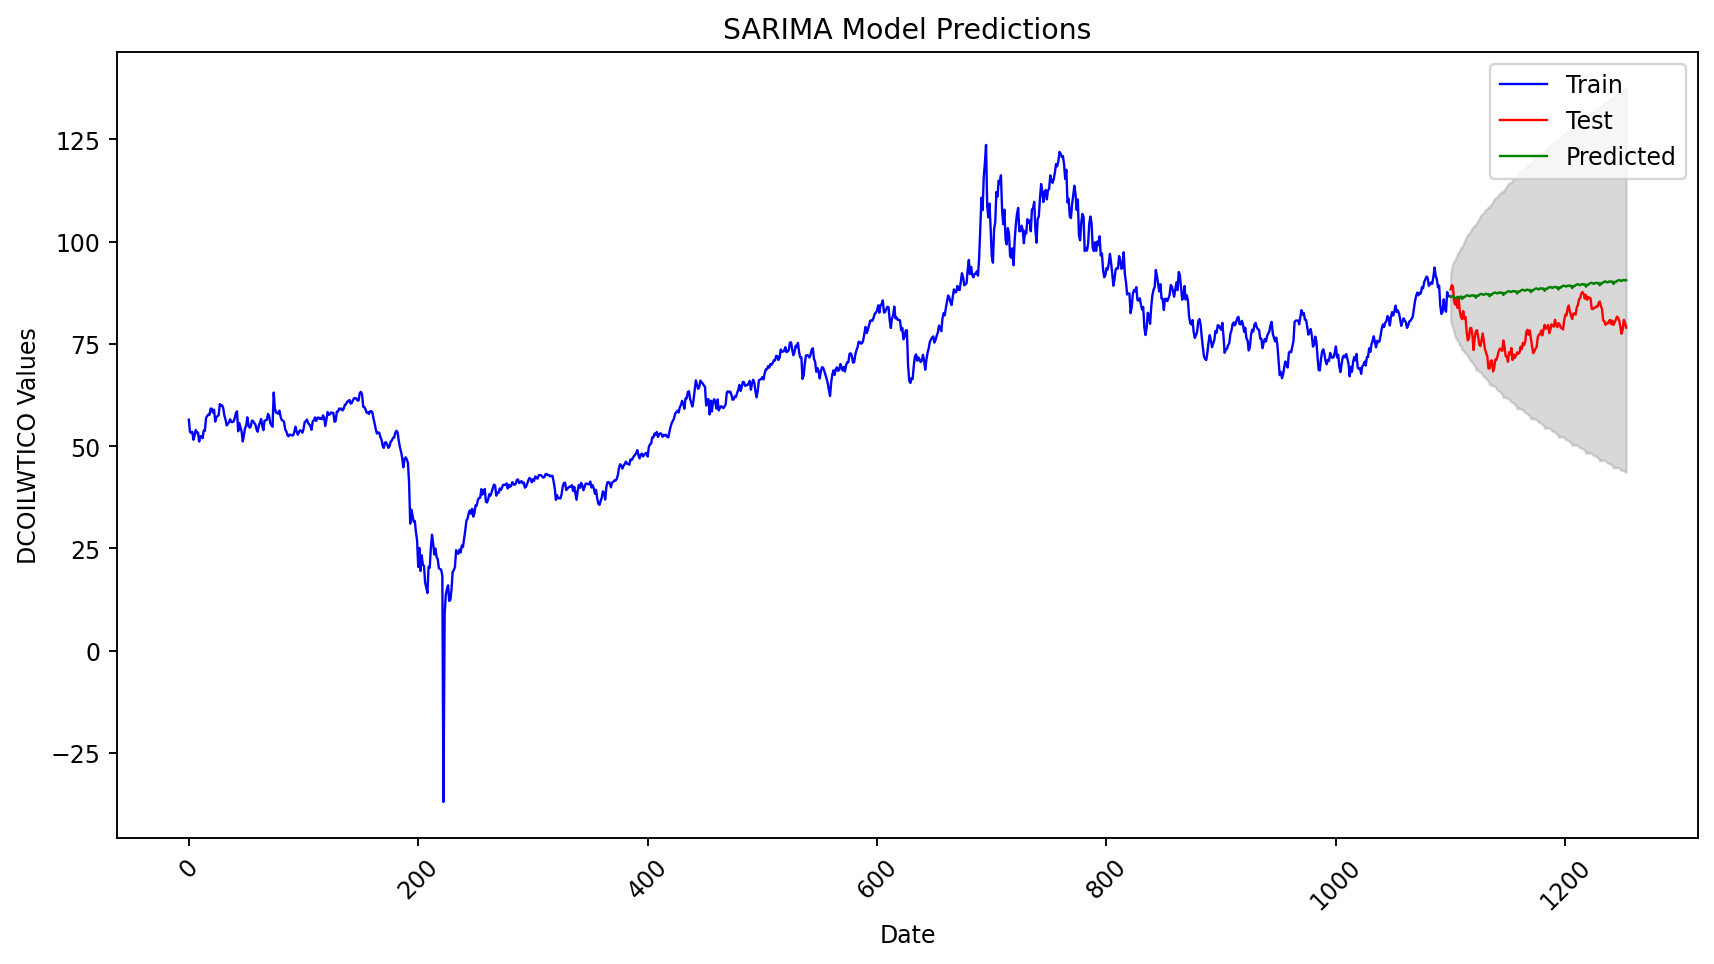

In [7]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Get predictions for training set
train_pred = model_fit1.predict(start=0, end=len(train_data) - 1)

# Calculate MSE and RMSE for training data
train_mse = mean_squared_error(train_data, train_pred)
train_rmse = np.sqrt(train_mse)

# Calculate MSE and RMSE for test data using the predictions
test_mse = mean_squared_error(test_data, pred.predicted_mean)
test_rmse = np.sqrt(test_mse)

# Print the results
print(f"Training MSE: {train_mse:.2f}")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Test MSE: {test_mse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")

# Plot the results
plt.figure(figsize=(12, 6), dpi=170)
plt.plot(train_data, label='Train', color='blue', linewidth=1)
plt.plot(test_data, label='Test', color='red', linewidth=1)
plt.plot(pred.predicted_mean, label='Predicted', color='green', linewidth=1)
plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='gray', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('DCOILWTICO Values')
plt.title('SARIMA Model Predictions')
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [ ]:
y_pred = pred.predicted_mean

# Extract only numeric values for MSE and RMSE calculation
y_test = test_data['y'].values  # Replace 'y' with the actual column name if different
y_pred = y_pred.values  # Convert predictions to a NumPy array

# Calculate MSE and RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"SARIMA Model Test MSE: {mse}")
print(f"SARIMA Model Test RMSE: {rmse}")

SARIMA Model Test MSE: 112.28997265767391
SARIMA Model Test RMSE: 10.596696308646102


In [ ]:
y_pred_tr = pred.predicted_mean

# Extract only numeric values for MSE and RMSE calculation
y_test = test_data['y'].values  # Replace 'y' with the actual column name if different
y_pred = y_pred.values  # Convert predictions to a NumPy array

# Calculate MSE and RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"SARIMA Model Test MSE: {mse}")
print(f"SARIMA Model Test RMSE: {rmse}")

In [4]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.9 MB/s eta 0:00:00
